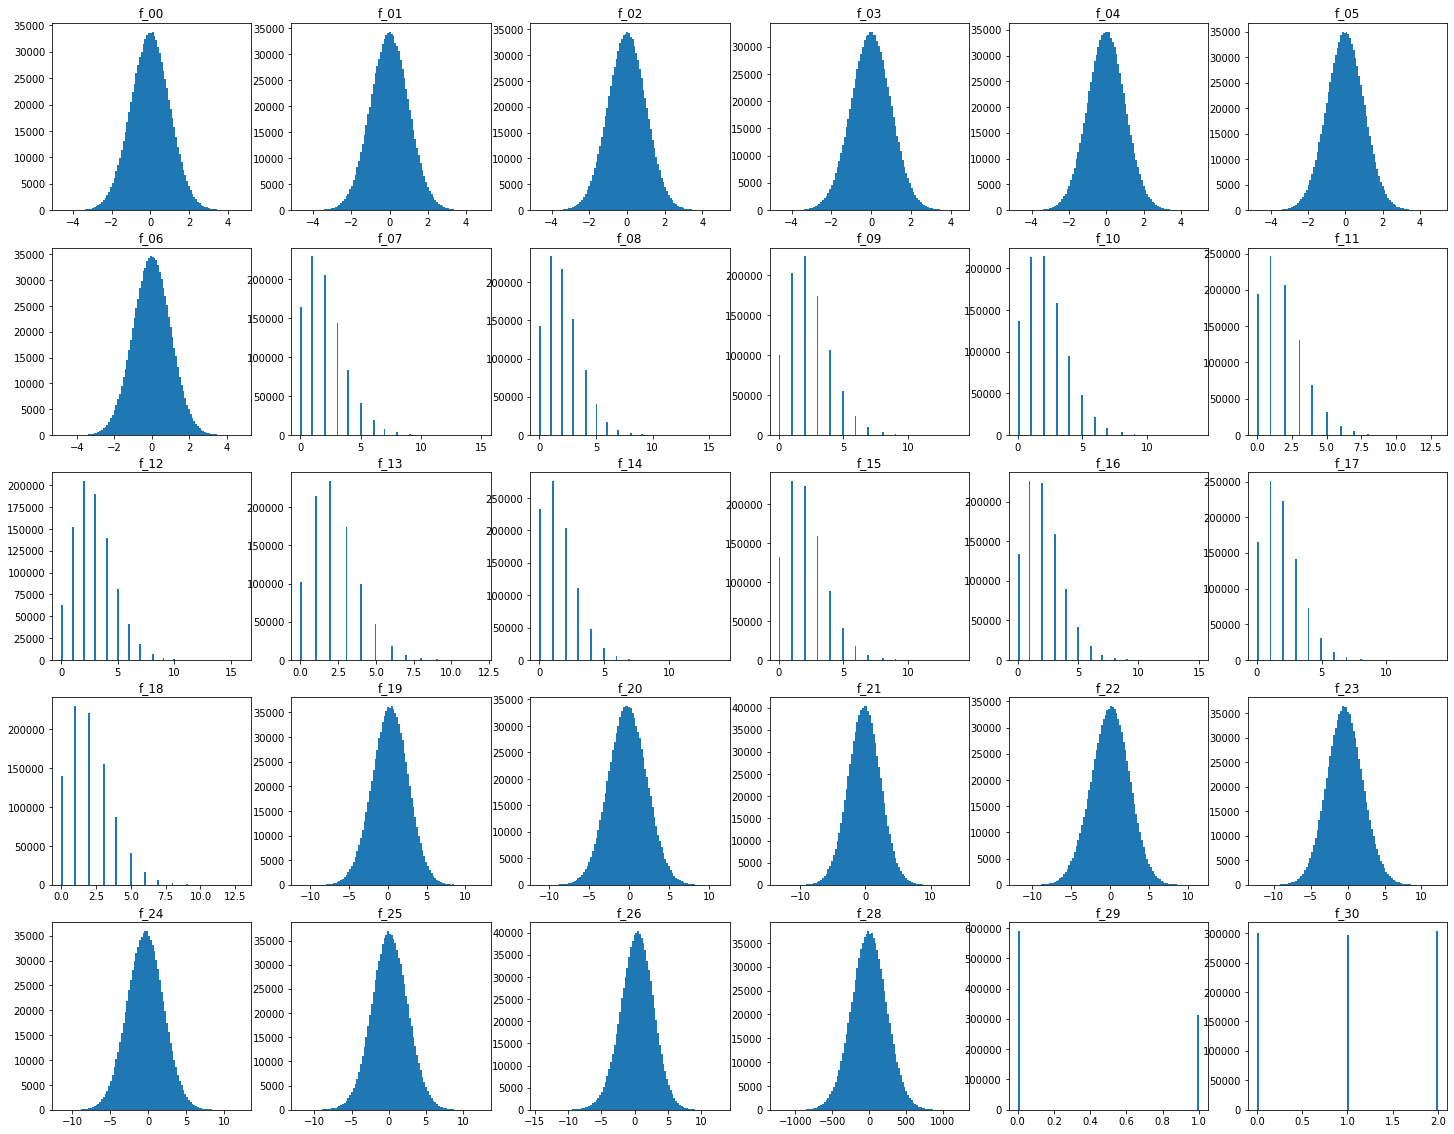

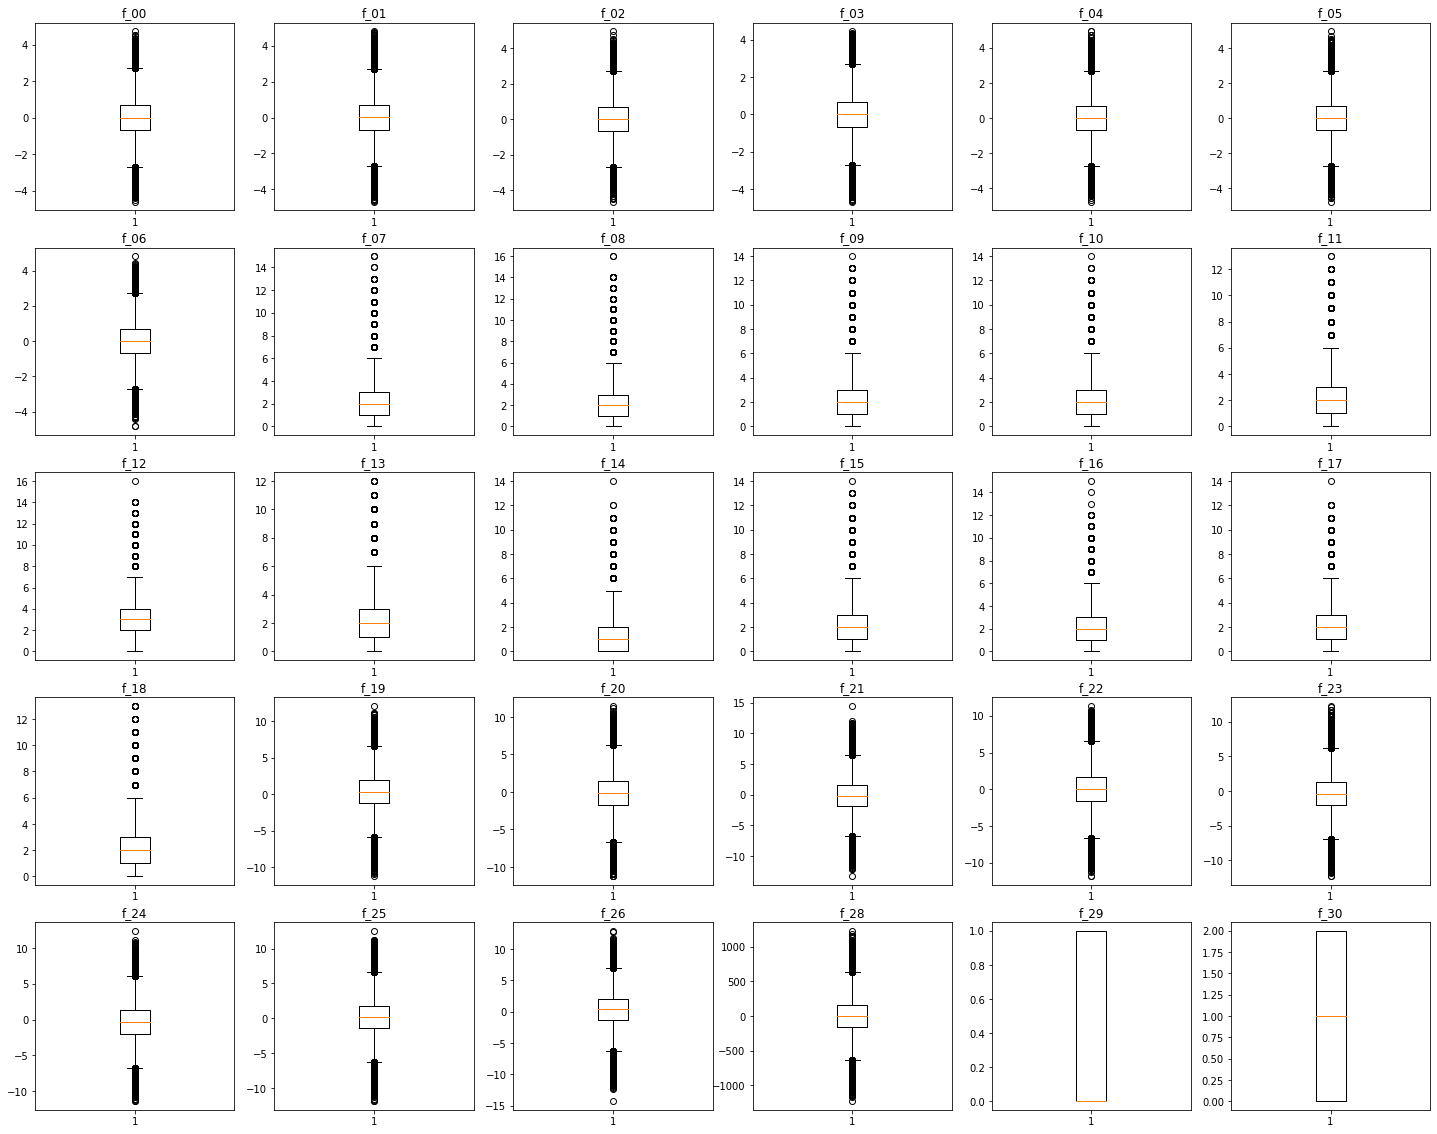

Optimization terminated successfully.
         Current function value: 0.652778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652639
         Iterations 5
Using train AUC: 0.6591300425455141
Using valid AUC: 0.6578942773798898
Optimization terminated successfully.
         Current function value: 0.652641
         Iterations 5
Using train AUC: 0.6591228917117927
Optimization terminated successfully.
         Current function value: 0.653271
         Iterations 5
Using valid AUC: 0.6579417845927349
Optimization terminated successfully.
         Current function value: 0.667687
         Iterations 4
Using feature selection train AUC: 0.6262400541902297
Optimization terminated successfully.
         Current function value: 0.668047
         Iterations 4
Using feature selection valid AUC: 0.6249988239983069


"\nf_27_test = test['f_27']\nf_27_test_len = pd.DataFrame(f_27_test).assign(string_len = f_27_test.apply(lambda x: len(x)))\n## f_27 in test set also has 10 characters\n\nf_27_test_columns = pd.DataFrame()\nfor i in range(0,10):\n    f_27_test_one_column = f_27_test.apply(lambda x: x[i])\n    f_27_test_one_column = labelencoder.fit_transform(f_27_test_one_column)\n    f_27_test_one_column = pd.DataFrame(f_27_test_one_column).rename(columns = {0:'f_27_'+str(i)})\n    f_27_test_columns = pd.concat([f_27_test_columns,f_27_test_one_column], axis = 1)\n    \ntest_drop_f_27 = test.drop(columns = 'f_27').reset_index()\ntest_id = test_drop_f_27['id']\ntest_w_text = pd.concat([test_drop_f_27.drop(columns = 'id'),f_27_test_columns], axis = 1)\ntest_text_pred = pd.DataFrame(xgb_model_10.predict(test_w_text))\nfinal_submission = pd.concat([test_id,test_text_pred], axis = 1).rename(columns = {0:'target'})\nfinal_submission.to_csv('final_submission w text.csv', index = False)\n"

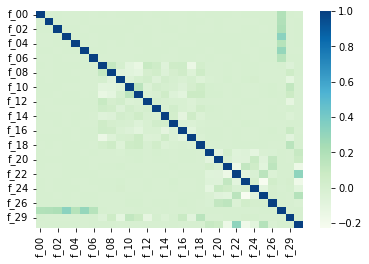

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import anderson
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv').set_index('id')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv').set_index('id')

df_eda = df.drop(columns = ['f_27', 'target']).agg(['mean','median','max','min','skew','kurtosis'])

ind_var = df.drop(columns = ['f_27', 'target'])
df_melt = pd.melt(ind_var)

fig,ax = plt.subplots(5,6, figsize=(25,20))

i = 0
j = 0
for col in ind_var.columns:
    ax[j,i].hist(df[col], bins = 100)
    ax[j,i].set_title(col)
    if i ==5:
        i = 0
        j = j+1
    else:
        i = i +1
        
        
plt.show()

## From the histogram, we can see that some 
## features (00-06,19-28) are continuous
## while some features (07-18,30) are decrete, also tends to be positively skewed
## f_29 explicitly only has 1s and 0s, meaning its probably a categorical data

fig,ax = plt.subplots(5,6, figsize=(25,20))

i = 0
j = 0
for col in ind_var.columns:
    ax[j,i].boxplot(df[col])
    ax[j,i].set_title(col)
    if i ==5:
        i = 0
        j = j+1
    else:
        i = i +1
          
plt.show()
## More or less confirms readings in histogram
### Impact:
### we can use linear based models on continuous features
### descrete variables needs more investigation because it
### it looks like a truncated normal distribution
### we will use Anderson Darling test to determine distribution

descrete_cols = df.iloc[:,7:19]

result_test = []
for col in descrete_cols.columns:
    result = anderson(df.loc[:,col], 'norm')
    result_df = pd.DataFrame([[col,result[0],result[1][2],result[2][2]]], columns = ['column','t-stat','crit value','sig.']).set_index('column')
    result_test.append(result_df)
result_test = pd.concat(result_test)
### All t-statistics are greater than critical values
### So f_07-f_18 are normal distributions, just truncated
### to be above 0

# Dependent variable
dep_var = df['target'].value_counts()
## 0 - 462,161 1 - 437839
## Data is balanced

# Variable heatmap
ax1 = sns.heatmap(ind_var.corr(), cmap = 'GnBu')
## Based on correlation heatmap, none of the numeric variable
## have a strong correlation with one another
## No variables to remove based on this finding

# Logistic regression
x = ind_var
y = df['target']
model1 = sm.Logit(y,x).fit()

'''
At 5% confidence level, all variables are significant except for:
f_03
f_04
f_06
f_12
f_28
Current pseudo r-squared: 0.05%
'''

x1 = x.drop(columns = ['f_03','f_04','f_06','f_12','f_28'])
model2 = sm.Logit(y,x1).fit()

'''
Psudo r-squared remains the same, to use other methods to test accuracy
'''

# training and predicting model
train2,valid2 = train_test_split(df.drop(columns = 'f_27'), test_size = 0.2, random_state= 33)

x2 = train2.drop(columns = 'target')
y2 = train2['target']
model2 = sm.Logit(y2,x2).fit()
ypred_train2 = model2.predict(x2)
print('Using train AUC:', roc_auc_score(y2,ypred_train2) )

x3 = valid2.drop(columns = 'target')
y3 = valid2['target']
ypred_valid2 = model2.predict(x3)
print('Using valid AUC:', roc_auc_score(y3,ypred_valid2))

'''
Using train AUC: 0.6591300425455141
Using valid AUC: 0.6578942773798898
'''

x4 = x2.drop(columns = ['f_03','f_04','f_06','f_12','f_28'])
model4 = sm.Logit(y2,x4).fit()
ypred_train3 = model4.predict(x4)
print('Using train AUC:', roc_auc_score(y2,ypred_train3))

x5 = x3.drop(columns = ['f_03','f_04','f_06','f_12','f_28'])
model5 = sm.Logit(y3,x5).fit()
ypred_valid3 = model5.predict(x5)
print('Using valid AUC:', roc_auc_score(y3,ypred_valid3))
'''
Using train AUC: 0.6591228917117927
Using valid AUC: 0.6579417845927349
Practically no difference in AUC results
'''

## feature importance plot and sequentialfeatureselector
## Will not load again because it took 2 hours
'''
rf = RandomForestClassifier(random_state = 100)
rf.fit(x2,y2)
importances1 = rf.feature_importances_
impt_std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis = 0)
forest_importances = pd.Series(importances1, index = x2.columns)
fig,ax2 = plt.subplots()
forest_importances.plot.bar(yerr = impt_std, ax= ax2)
ax2.set_title('Feature importances using MDI')
ax2.set_ylabel('Mean decrease in impurity')
plt.savefig('Feature importances using MDI.pdf', bbox_inches = 'tight')
plt.show()
plt.close()
# f_18 - f_28 are the most important features
# However, upon further research, mean decreases in impurity (Gini)
# is biased towards continuous variables, which f_18 - f_28 are

## Feature permutation

permutation_result = permutation_importance(
    rf, x3, y3, n_repeats = 5,random_state = 33)
forest_importances1 = pd.Series(permutation_result.importances_mean, index = x3.columns)
fig, ax3 = plt.subplots()
forest_importances1.plot.bar(yerr = permutation_result.importances_std, ax = ax3)
ax3.set_title('Feature importances using permutation')
ax3.set_ylabel('Mean accuracy decrease')
plt.savefig('Feature importances using permutation on model.pdf')
plt.show()
plt.close()
## Looks like f_30 is the most important feature among them all
## f_19 - f_26 appears to be less important but still 
## relatively more important than other features

# Sequential Feature selector (Dropped because pc cannot handle)
#sfs = SequentialFeatureSelector(rf)
#sfs.fit(x2,y2)
'''
# Testing the new model with only permutationally important variables
x6 = x2[['f_19','f_20','f_21','f_22','f_23','f_24','f_25',
             'f_26','f_28','f_29','f_30']]
model6 = sm.Logit(y2,x6).fit()
ypred_train4 = model6.predict(x6)
print('Using feature selection train AUC:', roc_auc_score(y2, ypred_train4))

x7 = x3[['f_19','f_20','f_21','f_22','f_23','f_24','f_25',
             'f_26','f_28','f_29','f_30']]
model7 = sm.Logit(y3,x7).fit()
ypred_train5 = model7.predict(x7)
print('Using feature selection valid AUC:', roc_auc_score(y3, ypred_train5))
'''
Using feature selection train AUC: 0.6262400541902297
Using feature selection valid AUC: 0.6249988239983069
model performance became worse, maybe not all unimportant 
variables should be deleted
or logit regression might not fit the underlying dataset
'''

# Decision tree model 

dtc = DecisionTreeClassifier()
path = dtc.cost_complexity_pruning_path(x2, y2)
alphas = path['ccp_alphas']
alphas_list = list(alphas)

'''
Took too long to load, dropped

def tree_train_runs(alpha):
    tree_model = DecisionTreeClassifier(ccp_alpha = alpha)
    tree_model.fit(x2,y2)
    y_tree_model_train_pred = tree_model.predict(x2)
    return roc_auc_score(y2,y_tree_model_train_pred)

def tree_valid_runs(alpha):
    tree_model = DecisionTreeClassifier(ccp_alpha = alpha)
    tree_model.fit(x2,y2)
    y_tree_model_valid_pred = tree_model.predict(x3)
    return roc_auc_score(y3,y_tree_model_valid_pred)

tree_train = map(tree_train_runs, alphas_list)
tree_test = map(tree_valid_runs, alphas_list)

sns.set()
plt.figure(figsize = (14,7))
sns.lineplot(y = tree_train, x = alphas, label = 'Train Accuracy')
sns.lineplot(y = tree_test, x = alphas, label = 'Test Accuracy')
plt.xlabel('ccp_alpha')
plt.ylabel('AUC')
plt.savefig('AUC among alphas.pdf', bbox_inches = 'tight')
plt.show()
plt.close()
'''
# Usable models
'''
tree_model = DecisionTreeClassifier(ccp_alpha = alphas_list[1])
tree_model.fit(x2,y2)
y_tree_model_train_pred = tree_model.predict(x2)
print('Classification tree model 1 train AUC:', roc_auc_score(y2,y_tree_model_train_pred))
y_tree_model_valid_pred = tree_model.predict(x3)
print('Classification tree model 1 valid AUC:',roc_auc_score(y3, y_tree_model_valid_pred))


Classification tree model 1 train AUC: 0.9999986474789007
Classification tree model 1 valid AUC: 0.7298191610989236
Already better than logistic regression


tree_model_2 = DecisionTreeClassifier(ccp_alpha = alphas_list[len(alphas_list)-1])
tree_model_2.fit(x2,y2)
y_tree_model_2_train_pred = tree_model_2.predict(x2)
print('Classification tree model 2 train AUC:', roc_auc_score(y2,y_tree_model_2_train_pred))
y_tree_model_2_valid_pred = tree_model_2.predict(x3)
print('Classification tree model 2 valid AUC:',roc_auc_score(y3, y_tree_model_2_valid_pred))


Classification tree model 2 train AUC: 0.5
Classification tree model 2 valid AUC: 0.5


# Randomforest
tree_model_3 = RandomForestClassifier(ccp_alpha = alphas_list[1])
tree_model_3.fit(x2,y2)
randomforest_model_3_train_pred = tree_model_3.predict(x2)
print('Classification tree model 3 train AUC:', roc_auc_score(y2,randomforest_model_3_train_pred))
randomforest_model_3_valid_pred = tree_model_3.predict(x3)
print('Classification tree model 3 valid AUC:',roc_auc_score(y3, randomforest_model_3_valid_pred))

Classification tree model 3 train AUC: 0.9999986474789007
Classification tree model 3 valid AUC: 0.8248580798463236
Alot better than decision tree


#XGBoost
xgb_model_4 = XGBClassifier(gamma = alphas_list[1])
xgb_model_4.fit(x2,y2)
xgb_model_4_train_pred = xgb_model_4.predict(x2)
print('XGBoost model 4 train AUC:',roc_auc_score(y2,xgb_model_4_train_pred))
xgb_model_4_valid_pred = xgb_model_4.predict(x3)
print('XGBoost model 4 valid AUC:', roc_auc_score(y3,xgb_model_4_valid_pred))

XGBoost model 4 train AUC: 0.8538237386843496
XGBoost model 4 valid AUC: 0.845515873139556
Slightly better than randomforest


# Emsembling by stacking (combine multiple models together)
estimators = [
    ('Decisiontree', DecisionTreeClassifier(ccp_alpha = alphas_list[1])),
    ('randomforest', RandomForestClassifier(ccp_alpha = alphas_list[1])),
    ('xgboost', XGBClassifier(gamma = alphas_list[1]))]

stacked_model_5 = StackingClassifier(estimators = estimators,
                                     final_estimator = XGBClassifier())
stacked_model_5.fit(x2,y2)
stack_model_5_train_pred = stacked_model_5.predict(x2)
print('stacked model 5 train AUC:', roc_auc_score(y2,stack_model_5_train_pred))
stack_model_5_valid_pred = stacked_model_5.predict(x3)
print('stacked model 5 valid AUC:', roc_auc_score(y3,stack_model_5_valid_pred))

stacked model 5 train AUC: 0.9356863451866607
stacked model 5 valid AUC: 0.850956509816447
Slightly better than xgboost but significantly longer loading time, not worth it
'''

# K-Nearest Neighbours (KNN) (Dropped because loads too long)
'''
sc = StandardScaler()
knn_train = sc.fit_transform(x2)
knn_valid = sc.transform(x3)

knn_model_6 = KNeighborsClassifier(n_neighbors = 5)
knn_model_6.fit(knn_train,y2)
knn_train_pred = knn_model_6.predict(knn_train)
print('knn model 6 train AUC:', roc_auc_score(y2,knn_train_pred))
knn_valid_pred = knn_model_6.predict(knn_valid)
print('knn model 6 valid AUC:',roc_auc_score(y3, knn_valid_pred))
'''
#Support Vector Classification (SVC)
'''
sc = StandardScaler()
svc_train = sc.fit_transform(x2)
svc_valid = sc.transform(x3)


svc_model_7 = LinearSVC(random_state = 100, tol = 1e-05)
svc_model_7.fit(svc_train,y2)
svc_train_pred = svc_model_7.predict(svc_train)
print('svc model 7 train AUC:', roc_auc_score(y2,svc_train_pred))
svc_valid_pred = svc_model_7.predict(svc_valid)
print('svc model 7 valid AUC:', roc_auc_score(y3,svc_valid_pred))

svc model 7 train AUC: 0.6140088124949995
svc model 7 valid AUC: 0.6128761606811465
Not surprising considering dataset is not linear from
the poor results from logistic regression
'''

# Using XGBoost with permutationally important variables
'''
xgb_model_8 = XGBClassifier(gamma = alphas_list[1])
xgb_model_8.fit(x6,y2)
xgb_model_8_train_pred = xgb_model_8.predict(x6)
print('xgb model 8 train AUC:',roc_auc_score(y2,xgb_model_8_train_pred))
xgb_model_8_valid_pred = xgb_model_8.predict(x7)
print('xgb model 8 valid AUC:', roc_auc_score(y3,xgb_model_8_valid_pred))

xgb model 8 train AUC: 0.7949018698531616
xgb model 8 valid AUC: 0.7856326291908703
Removing permutationally important variables confirmed to make models worse
'''
'''
#Using XGBoost model 4 to predict test set
xgb_model_4 = XGBClassifier(gamma = alphas_list[1])
xgb_model_4.fit(x2,y2)
test_for_model = test.drop(columns = 'f_27')
test_pred = pd.DataFrame(xgb_model_4.predict(test_for_model))
test_id = pd.DataFrame(test_for_model.index)
test_pred_final = pd.concat([test_id,test_pred], axis = 1).rename(columns = {0:'target'})
test_pred_final.to_csv('final result.csv', index = False)

First attempt score: 0.84559
Based on kaggle discussion, using XGBoost on all features
guarentees score of 0.9+, removal of f_27 brings it down to
0.85.
''' 

# Attempt to include f_27 into model
f_27 = df['f_27']
f_27_eda = f_27.drop_duplicates().agg('count')
f_27_counts = f_27.value_counts()
## There are 741354 unique values in f_27, values appeared at 
## 12 times, at least once

string_length = pd.DataFrame(f_27).assign(length = f_27.apply(lambda x: len(x)))
## The strings are 10 characters long

labelencoder = LabelEncoder()
f_27_columns = pd.DataFrame()
for i in range(0,10):
    f_27_one_column = f_27.apply(lambda x: x[i])
    f_27_one_column = labelencoder.fit_transform(f_27_one_column)
    f_27_one_column = pd.DataFrame(f_27_one_column).rename(columns = {0:'f_27_'+str(i)})
    f_27_columns = pd.concat([f_27_columns,f_27_one_column], axis = 1)

# create and test new model
split_df = pd.concat([df.drop(columns = 'f_27'),f_27_columns],axis = 1)
train8,valid8 = train_test_split(split_df, test_size = 0.2, random_state = 33)
x8 = train8.drop(columns = 'target')
y8 = train8['target']
x9 = valid8.drop(columns = 'target')
y9 = valid8['target']

'''
xgb_model_9 = XGBClassifier(gamma = alphas_list[1])
xgb_model_9.fit(x8,y8)
xgb_model_9_train_pred = xgb_model_9.predict(x8)
print('xgb model 8 with text train AUC:',roc_auc_score(y8,xgb_model_9_train_pred))
xgb_model_9_valid_pred = xgb_model_9.predict(x9)
print('xgb model 9 with text valid AUC:', roc_auc_score(y9,xgb_model_9_valid_pred))

xgb model 8 with text train AUC: 0.8925556784660948
xgb model 9 with text valid AUC: 0.8843677406420254
Surprisingly strong model, even beats ensemble
'''
# Applying model to actual test set
'''
train_w_text = pd.concat([x,f_27_columns], axis = 1)
xgb_model_10 = XGBClassifier(gamma = alphas_list[1])
xgb_model_10.fit(train_w_text,df['target'])
'''
'''
f_27_test = test['f_27']
f_27_test_len = pd.DataFrame(f_27_test).assign(string_len = f_27_test.apply(lambda x: len(x)))
## f_27 in test set also has 10 characters

f_27_test_columns = pd.DataFrame()
for i in range(0,10):
    f_27_test_one_column = f_27_test.apply(lambda x: x[i])
    f_27_test_one_column = labelencoder.fit_transform(f_27_test_one_column)
    f_27_test_one_column = pd.DataFrame(f_27_test_one_column).rename(columns = {0:'f_27_'+str(i)})
    f_27_test_columns = pd.concat([f_27_test_columns,f_27_test_one_column], axis = 1)
    
test_drop_f_27 = test.drop(columns = 'f_27').reset_index()
test_id = test_drop_f_27['id']
test_w_text = pd.concat([test_drop_f_27.drop(columns = 'id'),f_27_test_columns], axis = 1)
test_text_pred = pd.DataFrame(xgb_model_10.predict(test_w_text))
final_submission = pd.concat([test_id,test_text_pred], axis = 1).rename(columns = {0:'target'})
final_submission.to_csv('final_submission w text.csv', index = False)
'''
## Final score: 0.88688
